이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 '사전 훈련된 워드 임베딩을 이용한 의도 분류' 튜토리얼입니다.  

링크 : https://wikidocs.net/86083  

### **※ Colab으로 실행!!!**

## **11-06 사전 훈련된 워드 임베딩을 이용한 의도 분류(Intent Classification using Pre-trained Word Embedding)**
---

의도 분류(Intent Classification)는 개체명 인식(Named Entity Recognition)과 더불어 챗봇(Chatbot)의 중요 모듈로서 사용될 수 있습니다. 사전 훈련된 워드 임베딩(Pre-traiend word embedding)을 입력으로 의도 분류를 수행해봅시다. 의도 분류 실습은 결국 텍스트 분류입니다.

---
### **1. 데이터 로드와 전처리**


In [ ]:
import tensorflow as tf   # 2024.08 tf 2.17.0
tf.__version__

'2.18.0'

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

깃허브로부터 의도 데이터를 다운로드하여 데이터프레임에 로드합니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

('intent_test_data.csv', <http.client.HTTPMessage at 0x7a8760bec050>)

In [ ]:
train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

훈련 데이터를 로드한 데이터프레임을 출력해봅시다.

In [ ]:
train_data

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist
...,...,...
11779,can a i get the movie schedule for sympathy fo...,SearchScreeningEvent
11780,find movie schedules for animated movies aroun...,SearchScreeningEvent
11781,what time is bordertown trail showing,SearchScreeningEvent
11782,in the neighbourhood find movies with movie times,SearchScreeningEvent


테스트 데이터를 로드한 데이터프레임을 출력해봅시다.

In [ ]:
test_data

,intent,label
0,i 'd like to have this track onto my classical...,AddToPlaylist
1,add the album to my flow espa ol playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist
...,...,...
595,is any cinema playing the spirit of youth,SearchScreeningEvent
596,what are the movie times for animated movies i...,SearchScreeningEvent
597,what 's the movie schedule at great escape the...,SearchScreeningEvent
598,show the times for cheers for miss bishop at d...,SearchScreeningEvent


훈련 데이터와 테스트 데이터 그리고 레이블을 리스트로 저장하고 샘플 수를 출력해봅시다.

In [ ]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

In [ ]:
print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


In [ ]:
intent_train[:3]

['add another song to the cita rom ntica playlist',
 'add clem burke in my playlist pre party r b jams',
 'add live from aragon ballroom to trapeo']

In [ ]:
label_train[:3]

['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']

In [ ]:
# unique label을 뽑아보기
test_data.label.unique()

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'RateBook',
       'SearchCreativeWork', 'SearchScreeningEvent'], dtype=object)

훈련 데이터의 상위 5개 샘플과 레이블을 출력해봅시다.

In [ ]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


첫번째 샘플을 보면 'add another song to the cita rom ntica playlist'라는 문장의 레이블은 'AddToPlaylist'입니다. 이 문장의 의도는 이 곡을 플레이리스트에 추가해줘라는 의도입니다. 그 외에도 어떤 종류의 범주가 있는지 보려면 정확하게 인덱스를 2000씩 +하면서 출력해보면 됩니다.

In [ ]:
print(intent_train[2000:2002])
print(label_train[2000:2002])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']


In [ ]:
print(intent_train[4000:4002])
print(label_train[4000:4002])

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']


In [ ]:
print(intent_train[6000:6002])
print(label_train[6000:6002])

['rate the current album one points', 'i give a zero rating for this essay']
['RateBook', 'RateBook']


In [ ]:
print(intent_train[8000:8002])
print(label_train[8000:8002])

["i'm trying to find the show chant ii", 'find spirit of the bush']
['SearchCreativeWork', 'SearchCreativeWork']


In [ ]:
print(intent_train[10000:10002])
print(label_train[10000:10002])

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
['SearchScreeningEvent', 'SearchScreeningEvent']


이를 통해 눈치채셨겠지만, 사실 이 데이터는 일정한 순서로 배치되어져 있습니다. 그래서 뒤에서는 이 데이터를 랜덤으로 섞어주는 작업을 해줍니다. 훈련 데이터에 존재하는 레이블의 분포를 그래프로 시각화하여 보겠습니다.

<Axes: xlabel='label'>

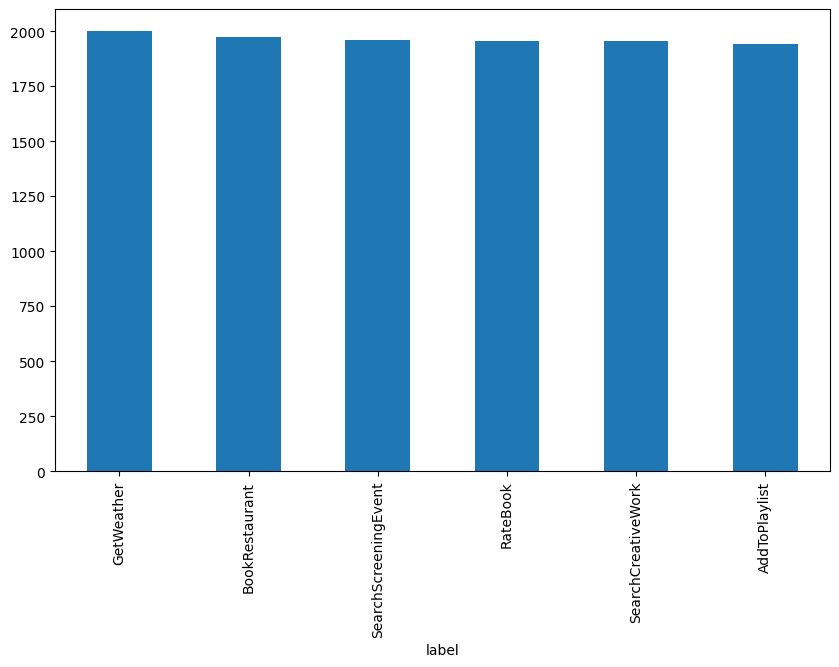

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar', figsize=(10, 6))

훈련 데이터에는 6개의 카테고리가 존재합니다. AddToPlaylist, BookRestaurant, GetWeather , RateBook , SearchCreativeWork, SearchScreeningEvent 각각의 데이터는 약 2,000개씩 존재합니다. label_train과 label_test에 존재하는 6개의 카테고리들을 고유한 정수로 인코딩해봅시다. 이런 경우에는 사이킷런(sklearn)의 preprocessing.LabelEncoder()가 유용합니다. label_idx에는 어떤 레이블이 어떤 정수에 맵핑되었는지 저장되어져 있습니다.

In [ ]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train) # 주어진 고유한 정수로 변환
label_test = idx_encode.transform(label_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

레이블과 정수의 맵핑 관계 : {np.str_('AddToPlaylist'): np.int64(0), np.str_('BookRestaurant'): np.int64(1), np.str_('GetWeather'): np.int64(2), np.str_('RateBook'): np.int64(3), np.str_('SearchCreativeWork'): np.int64(4), np.str_('SearchScreeningEvent'): np.int64(5)}


In [ ]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
[0 0 0 0 0]


훈련 데이터의 레이블과 테스트 데이터의 레이블 데이터를 상위 5개씩만 출력해봅시다.

In [ ]:
print(intent_test[:5])
print(label_test[:5])

["i 'd like to have this track onto my classical relaxations playlist", 'add the album to my flow espa ol playlist', 'add digging now to my young at heart playlist', 'add this song by too poetic to my piano ballads playlist', 'add this album to old school death metal']
[0 0 0 0 0]


이전에 'AddToPlaylist'라는 문자열로 저장되어져 있었던 레이블이 정수 0으로 변환되었습니다. 의도 문장에 대해서도 정수 인코딩을 진행해봅시다. 우선 의도 문장에 대해서 토큰화를 수행하고 단어 집합(vocabulary)을 만듭니다. 이어서 정수 인코딩을 수행하여 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

단어 집합의 크기를 확인해보겠습니다.

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


In [ ]:
print(word_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'for': 5, 'of': 6, 'at': 7, 'i': 8, 'is': 9, 'book': 10, 'add': 11, 'what': 12, 'find': 13, 'my': 14, 'playlist': 15, 'this': 16, '6': 17, 'movie': 18, 'me': 19, 'rate': 20, 'weather': 21, 'and': 22, 'be': 23, 'show': 24, 'give': 25, 'restaurant': 26, 'out': 27, 'will': 28, 'it': 29, 'on': 30, 'current': 31, 'stars': 32, 'forecast': 33, 'points': 34, 'playing': 35, 'can': 36, 'table': 37, 'want': 38, 'like': 39, "'s": 40, 'movies': 41, 'from': 42, 'album': 43, 'now': 44, 'that': 45, 'need': 46, '1': 47, 'called': 48, 'one': 49, 'schedule': 50, 'are': 51, 'theatres': 52, 'with': 53, 'you': 54, 'please': 55, "'d": 56, '2': 57, 'house': 58, 'four': 59, 'time': 60, 'song': 61, 'reservation': 62, 'by': 63, '4': 64, '3': 65, 'where': 66, 'novel': 67, 'get': 68, 'rating': 69, 'put': 70, 'two': 71, 'three': 72, '5': 73, 'people': 74, 'animated': 75, 'five': 76, 'times': 77, 'schedules': 78, 'here': 79, 'films': 80, 'tune': 81, 'party': 82, 'saga': 83, 'tv':

패딩을 위해서 훈련 데이터의 길이 분포를 확인해보겠습니다.

문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


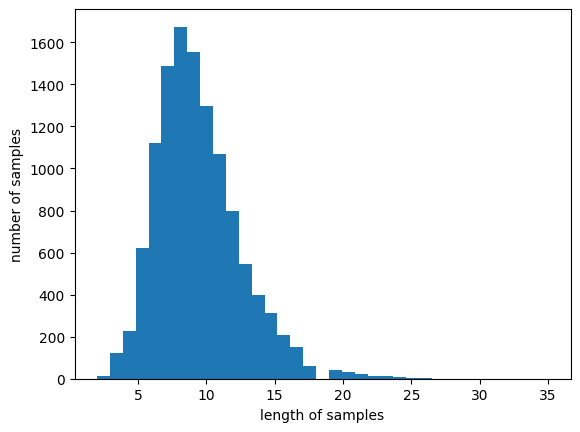

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=35)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장의 최대 길이는 35이므로, 최대 길이 35로 모든 훈련 데이터를 패딩하겠습니다. 레이블의 경우에는 다중 클래스 분류를 수행하기 위해서 원-핫 인코딩을 수행합니다.

In [ ]:
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


In [ ]:
print('훈련 데이터의 첫번째 샘플 :', intent_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :', label_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
훈련 데이터의 첫번째 샘플의 레이블 : [1. 0. 0. 0. 0. 0.]


훈련 데이터로부터 검증 데이터를 분리하겠습니다. 앞서 언급했듯이 훈련 데이터가 일정한 순서로 배치되어져 있으므로 훈련 데이터에서 앞의 10%나 중간 10%나 뒤의 10%를 검증 데이터로 분리했다가는 운이 나쁘면 특정 레이블의 데이터들만을 분리할 수도 있습니다. 가령, 검증 데이터에 0번 레이블의 데이터만 있다면 제대로 된 검증이 안 될 것입니다. 그래서 검증 데이터로 분리하기 전에 훈련 데이터의 순서를 랜덤으로 섞어주겠습니다. 이를 위해 순서가 뒤죽박죽의 정수 시퀀스를 만들어줍니다.

In [ ]:
intent_train.shape, intent_train

((11784, 35),
 array([[   0,    0,    0, ..., 1141, 1572,   15],
        [   0,    0,    0, ...,  256,  188,  548],
        [   0,    0,    0, ..., 4014,    4, 1968],
        ...,
        [   0,    0,    0, ..., 9869,  929,  103],
        [   0,    0,    0, ...,   53,   18,   77],
        [   0,    0,    0, ...,    1,  105,   41]], dtype=int32))

In [ ]:
## 순서 random으로 재배열
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :', indices)

랜덤 시퀀스 : [7291 2517 3483 ... 2752 1712 4861]


이 정수의 순서를 각 샘플의 순서가 되도록 훈련 데이터를 섞어줍니다.

In [ ]:
intent_train = intent_train[indices]
label_train = label_train[indices]

검증 데이터는 훈련 데이터 중 10%만을 사용합니다. 훈련 데이터의 개수에 0.1를 곱하면 몇 일까요?

In [ ]:
n_of_val = int(0.1 * intent_train.shape[0])
print('검증 데이터의 개수 :', n_of_val)

검증 데이터의 개수 : 1178


1,178이네요. 검증 데이터는 1,178개만 사용하도록 훈련 데이터에서 분리해줍니다.

In [ ]:
## 앞에서 1178개 -> train으로,
X_train = intent_train[: -n_of_val]
y_train = label_train[: -n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

In [ ]:
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


---
### **2. 사전 훈련된 워드 임베딩 사용하기**

스탠포드 대학교에서 제공하는 사전 훈련된 GloVe 임베딩을 사용합니다.

윈도우 환경을 사용하시는 분들은 http://nlp.stanford.edu/data/glove.6B.zip 링크에 가셔서 직접 다운로드하시고 압축푸시면 됩니다.

In [ ]:
## 다운로드 시간 (3분) : 822M
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip

--2025-06-13 06:29:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-13 06:29:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-13 06:29:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


아래 코드의 상세 내용은 사전 훈련된 워드 임베딩 실습을 참고하세요. 임베딩 벡터를 로드합니다.

In [ ]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
# embedding_dict

총 40만개의 임베딩 벡터가 존재합니다. 임의로 사전 훈련된 임베딩에서 단어 'respectable' 임베딩 벡터값과 벡터의 차원을 출력합니다.

In [ ]:
print(embedding_dict['respectable'])
print(embedding_dict['respectable'].shape)

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

임베딩 벡터의 차원은 100차원입니다. 이번 실습에서 사용할 임베딩 테이블을 구축해야합니다. 사전 훈련된 임베딩의 벡터의 차원이 100이므로 임베딩 테이블의 열도 100차원이어야 합니다. vocab_size를 행의 크기로, 열의 크기는 100인 테이블을 만듭니다.

In [ ]:
vocab_size

9870

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :', np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


훈련 데이터에 있는 단어와 사전 훈련된 워드 임베딩 벡터의 값을 맵핑하여 임베딩 테이블에 저장합니다.

In [ ]:
embedding_dict

Output hidden; open in https://colab.research.google.com to view.

In [44]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [45]:
embedding_matrix.shape

(9870, 100)

In [46]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.27085999,  0.044006  , -0.02026   , ..., -0.4923    ,
         0.63687003,  0.23642001],
       ...,
       [-0.75920999,  0.88966   ,  0.20953999, ..., -0.22462   ,
         0.81121999, -0.14551   ],
       [ 0.27102   ,  1.14999998, -0.21782   , ..., -0.080787  ,
        -0.36100999,  0.41297001],
       [-0.13378   , -0.52964997,  0.12538999, ...,  0.38256001,
        -0.47217   ,  0.77626002]])

---
### **3. 1D CNN을 이용한 의도 분류**

모델은 네이버 영화 리뷰 분류하기에서 사용했던 Multi-Kernel 1D CNN 구조를 하이퍼파라미터를 바꿔서 사용합니다.

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

In [48]:
kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)

model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 100)   │    987,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 34, 512)   │    102,912 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 33, 512)   │    154,112 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 512)   │    256,512 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1536)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │      9,222 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,509,758 (5.76 MB)

 Trainable params: 522,758 (1.99 MB)

 Non-trainable params: 987,000 (3.77 MB)

In [49]:
%%time
# colab T4 gpu : 2024.08
# Epoch 10/10
# 166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9989 - loss: 0.0050 - val_acc: 0.9856 - val_loss: 0.0578
# CPU times: user 17.6 s, sys: 1.1 s, total: 18.7 s
# Wall time: 22.3 s
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_val, y_val))

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - acc: 0.8583 - loss: 0.4308 - val_acc: 0.9703 - val_loss: 0.0930
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.9833 - loss: 0.0562 - val_acc: 0.9822 - val_loss: 0.0602
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9939 - loss: 0.0268 - val_acc: 0.9847 - val_loss: 0.0531
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9957 - loss: 0.0184 - val_acc: 0.9873 - val_loss: 0.0535
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9969 - loss: 0.0122 - val_acc: 0.9856 - val_loss: 0.0564
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9977 - loss: 0.0098 - val_acc: 0.9864 - val_loss: 0.0557
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9981 - loss: 0.0082 - val_acc: 0.9864 - val_loss: 0.0605
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9984 - loss: 0.0062 - val_acc: 0.9822 - val_loss: 0.0671
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

훈련 데이터에서 99%, 검증 데이터에서 98%의 정확도를 얻었습니다. 정확도와 loss의 변화를 그래프로 시각화해봅시다.

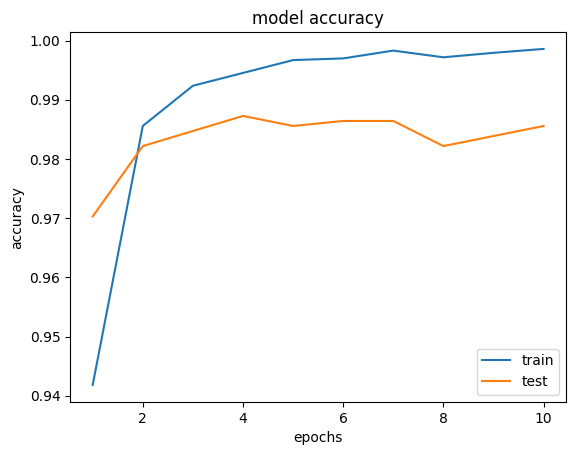

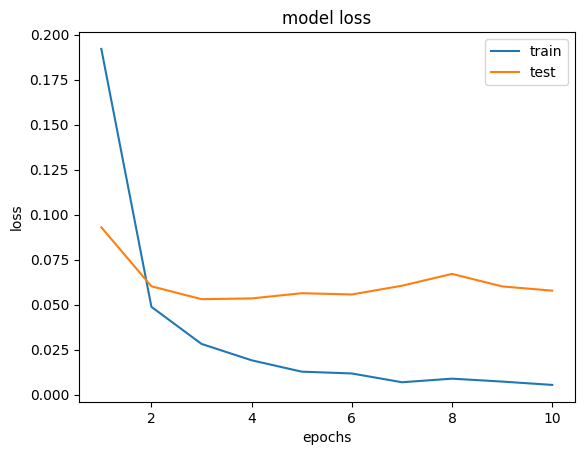

In [50]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

테스트 데이터에 대해서 평가해봅시다.

In [51]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [52]:
X_test

array([[  0,   0,   0, ...,  14, 299,  15],
       [  0,   0,   0, ..., 355, 470,  15],
       [  0,   0,   0, ...,   7, 365,  15],
       ...,
       [  0,   0,   0, ..., 268, 643,  52],
       [  0,   0,   0, ...,   7, 650,  52],
       [  0,   0,   0, ...,   7,   2,  85]], dtype=int32)

In [53]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측을 정수 시퀀스로 변환

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [54]:
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [55]:
y_predicted = idx_encode.inverse_transform(y_predicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
y_test = idx_encode.inverse_transform(y_test) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환

In [56]:
print('accuracy: ', sum(y_predicted == y_test) / len(y_test))
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, y_predicted))

accuracy:  0.9883333333333333
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       0.99      1.00      1.00       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.95      0.99      0.97       100
SearchScreeningEvent       0.99      0.94      0.96       100

            accuracy                           0.99       600
           macro avg       0.99      0.99      0.99       600
        weighted avg       0.99      0.99      0.99       600



99%의 정확도를 얻었습니다.

마지막 편집일시 : 2022년 11월 14일 4:20 오후